## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This report contains three different methods for testing the results of an A/B test run by an e-commerce website.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` The data are in the `ab_data.csv` file. 

a. Below is the pandas command for reading in the dataset; it is stored in the dataframe 'df':

In [2]:
df = pd.read_csv(r'C:\Users\Cvetana\Documents\Udacity projects\Data Analyst project 3\AnalyzeABTestResults 2\ab_data.csv')

The `.head()` method reveals the top few rows below:

In [3]:
# reveal column names:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


'group' and 'landing page' are the same variable (the independent variable). The values of 'converted' are the two possible outcomes of the experiment: '1' denotes a success.

b. The number of rows in the dataset are revealed by `shape`:

In [4]:
df.shape

(294478, 5)

There are 294,478 rows and 5 columns.

c. The number of unique users in the dataset is less than the number of rows:

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted:

In [6]:
# (len(df[df['converted']==1]))/df.shape[0]
df.converted.value_counts() / len(df)

0    0.880341
1    0.119659
Name: converted, dtype: float64

Not converted ('0'): 88% vs. converted ('1'): ca. 12%.

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# contingency table
pd.crosstab(index=df['group'], columns=df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


**Number of rows not matched:**

1928 + 1965 = 3893

These are the incorrect rows that need to be cleaned.

f. Below, we list the missing values for all columns:

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are no missing values.

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Below we save the cleaned up dataframe as **df2**.

In [9]:
df2 = df[((df['group'] =='control') & (df['landing_page'] =='old_page')) | ((df['group'] =='treatment') & (df['landing_page'] =='new_page'))]
df2.shape

(290585, 5)

The number of rows is now 290,585.

We check again whether all of the incorrect rows were removed with a boolean expression:

In [10]:
# The result should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` We now check for duplicated rows/users.

a. Number of unique **user_id**s in **df2**:

In [11]:
df2.user_id.nunique()

290584

b. Are there any repeated **user_id**s?

In [12]:
df2.duplicated(subset=['user_id']).any()

True

c. What is the row information for the repeated **user_id**? 

In [13]:
mask = df2.user_id.duplicated(keep=False)
print(df2[mask])

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


d. We remove one of the duplicated rows:

In [14]:
df2.drop([2893], axis = 0, inplace = True)

C:\Users\Cvetana\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


The number of rows is now equal to the unique user IDs:

In [15]:
df2.shape

(290584, 5)

`4.` Now, we compare the probabilities for converting revealed by the experiment so far.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
p_pop = (len(df2[df2['converted']==1]))/df2.shape[0]
print(p_pop)

0.11959708724499628


The probability to convert regardless of the experimental condition is ca. 11.96%.

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_ctrl = len(df2[(df2['converted']==1) & (df2['group']=='control')])/(len(df2[df2['group']=='control']))
print(p_ctrl)

0.1203863045004612


The probability to convert for users who received the old page was ca. 12%.

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_tr = len(df2[(df2['converted']==1) & (df2['group']=='treatment')])/(len(df2[df2['group']=='treatment']))
print(p_tr)

0.11880806551510564


The probability to convert for users who received the new page was ca. 11.88%.

Calculate the **actual difference** (`obs_diff`) between the conversion rates for the two groups.  

In [19]:
# actual difference between the conversion rates for the two groups:
obs_diff = p_tr - p_ctrl
print(obs_diff)

-0.0015782389853555567


The difference was about 0.16% higher for the old page.

d. What is the probability that an individual received the new page?

In [20]:
prob_new = (len(df2[df2['landing_page']=='new_page']))/df2.shape[0]
print(prob_new)

0.5000619442226688


An approximately equal number of users received the new and the old page: 50%.

e. Is there sufficient evidence to say that the new treatment page leads to more conversions?

**Interpretation:**

The new page is not better than the old page in terms of the number of users converted. In fact, the treatment diminished the probability to convert. This difference, however, is very small: the probability to convert for the users who viewed the new page was ca. 0,16% less compared to the ones who viewed the old page.

The reason could be that the test has not been run long enough and/ or with a sufficient number of users.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` We consider making the decision whether we should keep the old page based on all the data provided so far.

At a Type I error rate of 5%, the null and experimental hypotheses to be tested are:

**Experimental hypothesis:**

$H_0: p_{new} \le p_{old}$


$H_1: p_{new} > p_{old}$

or in terms of difference in proportions:

$H_0: p_{new} - p_{old} \le 0$

$H_1: p_{new} - p_{old} > 0$

#### 2. Hypothesis testing with bootstrap: simulating from the Null Hypothesis

Under the null hypothesis $H_0$, we assume that $p_{new}$ and $p_{old}$ are equal to each other and that they are both equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: 
<br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

$p_{new}$ = $p_{old}$ = $p_{population}$

In [21]:
# p_population:
p_pop = (len(df2[df2['converted']==1]))/df2.shape[0]
print(p_pop)

0.11959708724499628


The convert rate regardless of the experimental condition is ca. 11.96%.

a. What is the **convert rate** for $p_{new}$ under the null? 

$p_{new}$ = $p_{population}$

In [22]:
p_new = p_pop

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

$p_{old}$ = $p_{population}$

In [23]:
p_old = p_pop

c. How many users received the new page ($n_{new}$)?

In [24]:
# n_new and n_old:
df2.landing_page.value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [25]:
n_new = 145310

d. How many users received the old page ($n_{old}$)?

In [26]:
n_old = 145274

e. Next, we simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and store them in the variable **new_page_converted**:

In [27]:
# [0,1] are the values of converted; p = [0.8804, 0.1196] are the assigned probabilities to [0,1]:
new_page_converted = np.random.choice([0,1], size=n_new, replace=True, p=[0.8804, 0.1196])

f. Then, we simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null and store them as **old_page_converted**:

In [28]:
old_page_converted = np.random.choice([0,1], size=n_old, replace=True, p=[0.8804, 0.1196])

g. $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f):

In [29]:
p_new_min_p_old = new_page_converted.mean() - old_page_converted.mean()
p_new_min_p_old

0.0006241250926975056

The difference is 0.11% higher convert rate for the old page.

h. Next, we simulate 10,000 $p_{new}$ - $p_{old}$ values and store them in a numpy array called **diffs**.

In [30]:
diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
diffs = new_converted_simulation - old_converted_simulation

diffs = np.array(diffs)

i. Below is a histogram of the **diffs**. The red line denotes the actual (observed) difference:

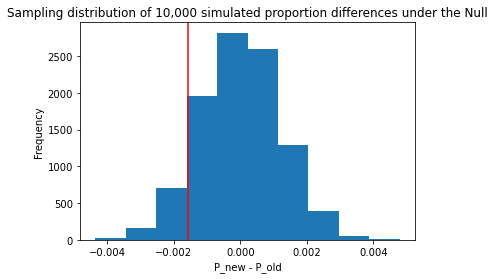

In [31]:
plt.hist(diffs)
plt.axvline(obs_diff, c='red')
plt.title('Sampling distribution of 10,000 simulated proportion differences under the Null')
plt.xlabel('P_new - P_old')
plt.ylabel('Frequency');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
(diffs > obs_diff).mean()

0.9058

**Interpretation:**

The computed p-value of 10,000 simulated differences between treatment and control samples amounts to 0.9058. Therefore, in 90.58% of the simulated samples under the null hypothesis the difference between $p_{new}$ and $p_{old}$ is greater than in the observed data. Furthermore, the observed difference is negative, while ~50% of the observed sample differences under the Null are positive, which explains the very high p-value.

Based on the bootstrap method, the decision would be to keep the old page.

l. We could also use a 2-sample z-test to achieve similar results. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

# number of conversions with the old_page
convert_old = sum((df2.group == 'control') & (df2.converted == 1))

# number of conversions with the new_page
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1))

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == "old_page"]['converted'].count()

# number of individuals who received new_page
n_new = df2[df2['landing_page'] == "new_page"]['converted'].count()

m. Now use `stats.proportions_ztest` to compute the test statistic and p-value. 

In [34]:
# alternative = 'larger' suggests a directed hypothesis ("new page leads to higher conversion rate")
converts = np.array([convert_new, convert_old])
samples = np.array([n_new, n_old])
stat, p_value = proportions_ztest(count=converts, nobs=samples, alternative='larger')
stat, p_value

(-1.3109241984234394, 0.9050583127590245)

**Interpretation:**

The p-value of the (directed) proportions z-test is estimated at .905, meaning that 90.5% of the sample proportion differences in the theoretical distribution of z-scores are higher than the observed one at a directed hypothesis (alternative = "larger"). The negative value of the z-statistic is related to the direction of the difference being opposed to the alternative hypothesis.

Based on a 2-sample z-test of proportions, the decision would be to keep the old page.

<a id='regression'></a>
### Part III - A regression approach

`1.` The result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. The dependent variable has two mutually exclusive values, therefore we perform logistic regression.

b. We use the **statsmodels** library to fit a logistic regression model to see if there is a significant difference in conversion based on the page-type a customer receives. 

We first need to create the following two columns in the `df2` dataframe:

 1. `intercept` with the value of `1` in the entire column. 
 2. `ab_page` - a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [35]:
# create intercept:
df2['intercept'] = 1

C:\Users\Cvetana\AppData\Local\Temp/ipykernel_6612/1808389073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1


In [36]:
# create dummy variables from the values of 'group':
df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
df2.head()

C:\Users\Cvetana\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [37]:
# rename 'treatment' into 'ab_page':
df2.rename(columns = {'treatment':'ab_page'}, inplace = True)
df2.head()

C:\Users\Cvetana\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [38]:
# the regression model rejects the original dummy data type 'uint8':
df2.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
control          uint8
ab_page          uint8
dtype: object

In [39]:
# cast the dummy variables as integers:
df2[['control', 'ab_page']] = df2[['control', 'ab_page']].astype('int64')
df2.dtypes

C:\Users\Cvetana\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
control          int64
ab_page          int64
dtype: object

c. Below, we instantiate and fit the regression model:

In [40]:
logit_01 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results01 = logit_01.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Then we provide a summary of the model:

In [41]:
results01.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-05-31 17:58 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

We exponentiate the coefficients to make them interpretable:

In [42]:
# exponentiate the coefficients:
np.exp(results01.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

We reciprocate the exponentiated coefficients due to partial probabilities:

In [43]:
# compute the reciprocal of the coefficients:
1/np.exp(results01.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value of the **A/B Test**?<br><br> 

The p-value associated with the coefficient for ab_page is 0.19 (higher than .05, i.e., not statistically significant). Therefore, according to the model tested, the new page does not change the possibility to convert compared to the old page.

**Interpretation:**

The logit model tests the intercept first, which corresponds to the control category, i.e., the old page.

Compared to the old page, the new page does not significantly increase the probability for converting.

The null and alternative hypotheses of the logit model are not directed. The null states that the probability to convert for the new and the old page is the same as the mean of both. The alternative hypothesis states that the probability to convert for the new page is different from that for the old page.


f. Now, we are considering other things that might influence whether or not an individual converts.

**Rationale for including other factors in the logistic regression model:**

Since there are data available about the country of residence of the users, we can test whether it influences the results in any way. The p-values of the coefficients and eventually also the model fit parameters can help in accessing whether this information is really valuable.

Testing multiple predictors could be **problematic** insofar as every hypothesis test inflates the family-wise error rate.

g. Now along with testing if the conversion rate changes for different pages, we add an effect based on which country a user lives in. First, we read in the **countries.csv** dataset and merge together the two datasets on the approporiate rows.

In [44]:
# read in the countries data:
countries_df = pd.read_csv(r'C:\Users\Cvetana\Documents\Udacity projects\Data Analyst project 3\AnalyzeABTestResults 2\countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


Next, we create an intercept column and dummy variables for the countries:

In [45]:
### Create the necessary dummy variables
# the regression reject the original data type of the dummy variables, therefore convert to integer below:
df_new['intercept'] = 1
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])
df_new.dtypes

country         object
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
control          int64
ab_page          int64
UK               uint8
US               uint8
CA               uint8
dtype: object

In [46]:
# convert dummy variables from uint8 to int64:
df_new[['UK', 'US', 'CA']] = df_new[['UK', 'US', 'CA']].astype('int64')
df_new.dtypes

country         object
timestamp       object
group           object
landing_page    object
converted        int64
intercept        int64
control          int64
ab_page          int64
UK               int64
US               int64
CA               int64
dtype: object

Below we fit the model with the USA as baseline country: 

In [47]:
# baseline country US (= only UK and CA are entered as factors):
logit_03 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA']])
results03 = logit_03.fit()
results03.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-05-31 17:58 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
CA           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

In [48]:
# exponentiate the model coefficients:
np.exp(results03.params)

intercept    0.138154
ab_page      0.985168
UK           0.950621
CA           0.990165
dtype: float64

In [49]:
# due to partial probability, compute the reciprocal of the exponentiated model coefficients:
1/np.exp(results03.params)

intercept    7.238314
ab_page      1.015056
UK           1.051944
CA           1.009932
dtype: float64

**Interpretation:**

Factor 'ab_page': when users in the USA receive the old page, they are 1.5% (1.015 times) more likely to convert.

Factor country: assuming the old page ('control') as baseline, and the USA as baseline country, the users in the UK and in Canada are 5.2% and 0.99%, resp., more likely to convert. 

However, none of the factors are statistically significant, therefore, the interpretation can be simply that the new page does not work in any of the three countries.

h. We would now like to look at an **interaction** between page and country to see if there are significant effects on conversion.  
Below, we create the necessary additional columns and fit the new model.  

In [50]:
# create new variables for the interaction effects
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_CA'] = df_new['ab_page'] * df_new['CA']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,UK,US,CA,ab_UK,ab_CA
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,0


In [51]:
### Fit the Linear Model And Obtain the Results
logit_04 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK','CA','ab_UK', 'ab_CA']])
results04 = logit_04.fit()
results04.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-05-31 17:58 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
UK           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
CA            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
ab_UK        -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
ab_CA        -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

In [52]:
# exponentiate the model coefficients:
np.exp(results04.params)

intercept    0.136392
ab_page      1.010893
UK           0.988285
CA           1.005761
ab_UK        0.924703
ab_CA        0.969090
dtype: float64

In [53]:
# due to predicted partial probabilities, compute the reciprocal of the exponentiated model coefficients:
1/np.exp(results04.params)

intercept    7.331806
ab_page      0.989224
UK           1.011854
CA           0.994272
ab_UK        1.081428
ab_CA        1.031896
dtype: float64

**Interpretation:**
    
Neither the country, nor the interactions between country and treatment are statistically significant at a p-level of .05 (furthermore, all CIs contain zero). The factor "new page" itself (i.e., "ab_page) is still not statistically significant. Thus, adding the users' contries of residence did not contribute to explaining the influence of the new page on convertion rate.

Whether these results are due to novelty aversion effect, remains to be seen after continuing the experiment for a sufficiently long time period.

<a id='conclusions'></a>
## Conclusions

The preliminary results of the A/B test point towards a possible aversion of the current users to the new site. 

It would be advisable, therfore, to continue running the experiment until a sufficient number of new users have been tested.

For now, the old page should be kept.